#**前置作業**

##引入模組

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Conv1D, LSTM, MaxPooling1D, Flatten, Dropout
from sklearn.svm import SVR
from keras.models import load_model


##定義參數

In [20]:
# 檔案、資料夾路徑參數
gdrive_path = '/content/drive'
project_folder_path = '/content/drive/MyDrive/Inundation_Forcasting/'
filename = 'AD.xlsx'
data_source_path = project_folder_path + 'data/'
data_source = data_source_path + filename
weights_path = project_folder_path + 'weights/'
output_path = project_folder_path + 'outputs/'

# 資料預處理參數
columns = ['RadarRainfall (mm)', 'AccRadarRainfall (mm)', 'Obv_467080', 'Obv_01U050', 'Obv_01U060', 'Obv_01U070', 'Obv_01U080', 'Obv_01U120', 'Obv_01U130', 'Obv_01U190', 'Obv_01U230', 'Obv_01U450', 'Obv_01U460', 'Obv_01U470', 'Obv_01U560', 'Obv_C0A570', 'Obv_C0U730', 'Obv_C1A630', 'Depth (cm)']
ref_columns = ['RadarRainfall (mm)', 'AccRadarRainfall (mm)', 'Obv_467080', 'Obv_01U050', 'Obv_01U060', 'Obv_01U070', 'Obv_01U080', 'Obv_01U120', 'Obv_01U130', 'Obv_01U190', 'Obv_01U230', 'Obv_01U450', 'Obv_01U460', 'Obv_01U470', 'Obv_01U560', 'Obv_C0A570', 'Obv_C0U730', 'Obv_C1A630']
pred_columns = ['Depth (cm)']
events = ['2008辛樂克颱風', '2009芭瑪颱風', '2010梅姬颱風', '2012蘇拉颱風', '2015蘇迪勒颱風']
num_events = 5

# 模型參數
epochs = 10
bpnn_epochs = 10000
batch_size = 16
lr = 0.01
loss = 'mse'
dropout_rate=0.2


##連接雲端硬碟

In [21]:
from google.colab import drive
drive.mount(gdrive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**副程式**

##資料處理工具

In [22]:
# 載入資料
def load_data(path):
    wb = openpyxl.load_workbook(path, data_only=True)
    events = [wb[sheetname] for sheetname in wb.sheetnames]
    for i in range(len(events)):
        events[i] = pd.DataFrame(get_values(events[i])).drop([0], axis=0)
        events[i].columns = columns
    return events

# 取得資料值並儲存為列表
def get_values(sheet):
    arr = [] 
    for row in sheet:
        temp = []  
        for column in row:
            temp.append(column.value)
        arr.append(temp)
    return arr

# 正規化資料(將資料範圍限縮在0~1之間，防止資料大小差異過大，影響模型訓練)
def normalize(data):
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return normalized_data

# 反正規化資料(將正規化的資料還原，用於結果呈現)
def denormalize(data, original):
    denormalized_data = data * (np.max(original) - np.min(original)) + np.min(original)
    return denormalized_data

# 分割訓練及測試資料
def split_data(X, Y, split_boundary):
    X_train = X[:split_boundary]
    Y_train = Y[:split_boundary]
    X_test = X[split_boundary:]
    Y_test = Y[split_boundary:]
    return X_train, Y_train, X_test, Y_test

# 產生資料及標籤
def create_sequences(events):
    df = pd.concat(events, ignore_index=True)
    df.columns = columns
    ref = df.loc[:, ref_columns]
    pred = df.loc[:, pred_columns]

    X, Y = [], []
    num_data = len(ref)
    for i in range(num_data):
        seq = ref.loc[i, ref_columns]
        label = pred.loc[i, pred_columns]
        X.append(seq)
        Y.append(label)

    X, Y = np.array(X), np.array(Y)
    X = X.reshape(X.shape[0], X.shape[1], 1).astype('float32')
    Y = Y.reshape(Y.shape[0], 1).astype('float32')

    return X, Y


##定義模型

###LSTM

In [23]:
class My_LSTM():
  def __init__(self):
    self.name = 'My_LSTM'

  def create_model(self, steps, features):
    model = Sequential(name="My_LSTM")
    model.add(LSTM(64, return_sequences=True, input_shape=(steps, features)))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(features))
    return model

  def train(self, data, show_training_history=True):
    X, Y, X_train, Y_train, X_test, Y_test = data
    model = self.create_model(X_train.shape[1], X_train.shape[2])
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=loss)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))
    if show_training_history:
      plt.plot(history.history['loss'], label='train')
      plt.plot(history.history['val_loss'], label='val')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()
    return model

  def save_model(self, model, filename):
    path = weights_path + filename + '.h5'
    model.save(path)
    print('training weights saved in ' + path)

  def predict(self, data, filename):
    X, Y, X_train, Y_train, X_test, Y_test = data
    model = load_model(weights_path + filename + '.h5')
    Y_predict = model.predict(X_test)
    Y_predict = denormalize(Y_predict, Y)
    Y_test = denormalize(Y_test, Y)
    return (Y_test, Y_predict)

  def save_result(self, result, filename, show=True):
    Y_test, Y_predict = result
    plt.plot(Y_test, color = 'red', label = 'Real Depth') 
    plt.plot(Y_predict, color = 'blue', label = 'Predicted Depth') 
    plt.title('Depth Prediction')
    plt.xlabel('Time')
    plt.ylabel('Depth (cm)')
    plt.legend()
    path = output_path + filename + '.png'
    plt.savefig(path)
    print('Prediction result saved in ' + path)
    if show:
      plt.show()


#**主程式**

##載入資料

Epoch 1/50
18/18 [==============================] - 6s 85ms/step - loss: 0.1294 - val_loss: 0.1112
Epoch 2/50
18/18 [==============================] - 0s 9ms/step - loss: 0.0999 - val_loss: 0.1026
Epoch 3/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0973 - val_loss: 0.1034
Epoch 4/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0875 - val_loss: 0.0987
Epoch 5/50
18/18 [==============================] - 0s 9ms/step - loss: 0.0790 - val_loss: 0.0186
Epoch 6/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0649 - val_loss: 0.0336
Epoch 7/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0698 - val_loss: 0.0572
Epoch 8/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0648 - val_loss: 0.0772
Epoch 9/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0669 - val_loss: 0.0398
Epoch 10/50
18/18 [==============================] - 0s 9ms/step - loss: 0.0565 - val_loss: 0.0227
Epoch 11/50


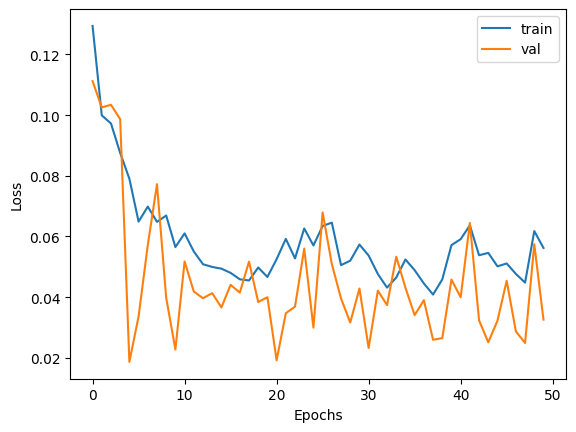

training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/LSTM_1.h5
3/3 [==============================] - 1s 6ms/step
Prediction result saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/LSTM_1.png


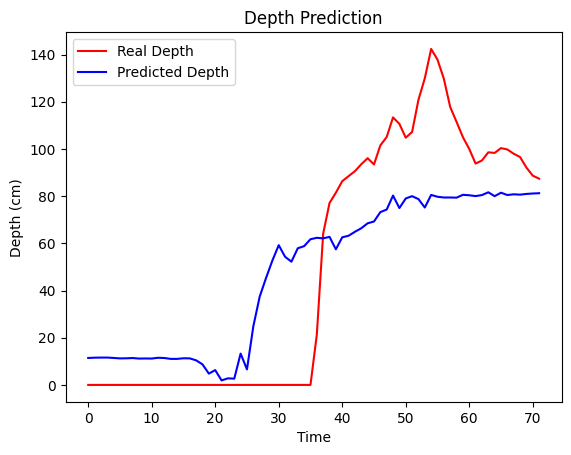

Epoch 1/50
18/18 [==============================] - 6s 88ms/step - loss: 0.7700 - val_loss: 0.0635
Epoch 2/50
18/18 [==============================] - 0s 10ms/step - loss: 0.1035 - val_loss: 0.0850
Epoch 3/50
18/18 [==============================] - 0s 10ms/step - loss: 0.1032 - val_loss: 0.0710
Epoch 4/50
18/18 [==============================] - 0s 9ms/step - loss: 0.1028 - val_loss: 0.0699
Epoch 5/50
18/18 [==============================] - 0s 10ms/step - loss: 0.1008 - val_loss: 0.1000
Epoch 6/50
18/18 [==============================] - 0s 10ms/step - loss: 0.1021 - val_loss: 0.0542
Epoch 7/50
18/18 [==============================] - 0s 11ms/step - loss: 0.0716 - val_loss: 0.0650
Epoch 8/50
18/18 [==============================] - 0s 14ms/step - loss: 0.0735 - val_loss: 0.0915
Epoch 9/50
18/18 [==============================] - 0s 15ms/step - loss: 0.0760 - val_loss: 0.0686
Epoch 10/50
18/18 [==============================] - 0s 15ms/step - loss: 0.0671 - val_loss: 0.1404
Epoch 11/5

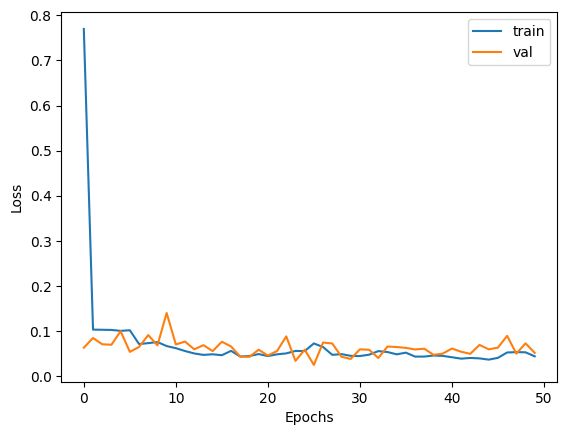

training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/LSTM_2.h5
3/3 [==============================] - 1s 6ms/step
Prediction result saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/LSTM_2.png


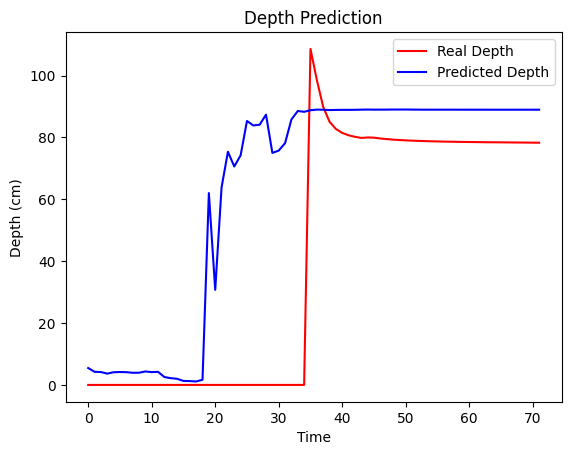

Epoch 1/50
18/18 [==============================] - 9s 82ms/step - loss: 0.7360 - val_loss: 0.1093
Epoch 2/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0954 - val_loss: 0.1103
Epoch 3/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0948 - val_loss: 0.1134
Epoch 4/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0987 - val_loss: 0.1114
Epoch 5/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0920 - val_loss: 0.1072
Epoch 6/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0908 - val_loss: 0.0898
Epoch 7/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0725 - val_loss: 0.1767
Epoch 8/50
18/18 [==============================] - 0s 11ms/step - loss: 0.0787 - val_loss: 0.1173
Epoch 9/50
18/18 [==============================] - 0s 10ms/step - loss: 0.1001 - val_loss: 0.1109
Epoch 10/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0923 - val_loss: 0.1122
Epoch 11/

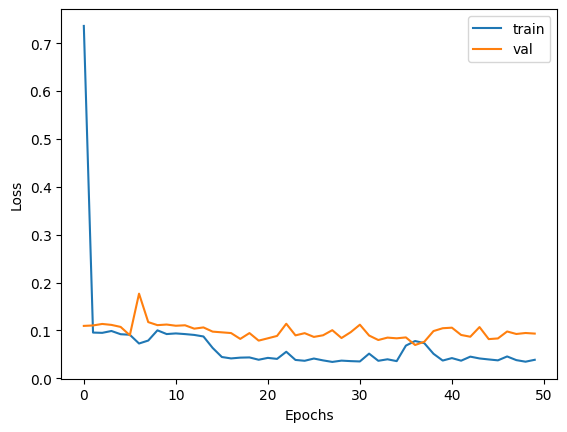

training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/LSTM_3.h5
3/3 [==============================] - 1s 7ms/step
Prediction result saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/LSTM_3.png


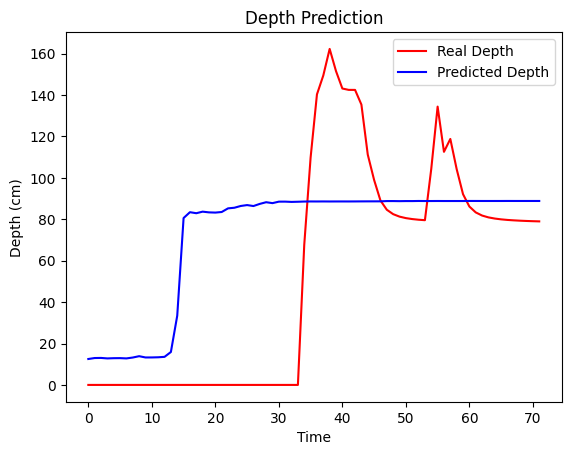

Epoch 1/50
17/17 [==============================] - 7s 90ms/step - loss: 0.3912 - val_loss: 0.1326
Epoch 2/50
17/17 [==============================] - 0s 19ms/step - loss: 0.1011 - val_loss: 0.1284
Epoch 3/50
17/17 [==============================] - 0s 19ms/step - loss: 0.0982 - val_loss: 0.1036
Epoch 4/50
17/17 [==============================] - 0s 18ms/step - loss: 0.0998 - val_loss: 0.0829
Epoch 5/50
17/17 [==============================] - 0s 17ms/step - loss: 0.0823 - val_loss: 0.0673
Epoch 6/50
17/17 [==============================] - 0s 18ms/step - loss: 0.0674 - val_loss: 0.1277
Epoch 7/50
17/17 [==============================] - 0s 17ms/step - loss: 0.0627 - val_loss: 0.0343
Epoch 8/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0606 - val_loss: 0.0820
Epoch 9/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0732 - val_loss: 0.0691
Epoch 10/50
17/17 [==============================] - 0s 18ms/step - loss: 0.0650 - val_loss: 0.1015
Epoch 11/

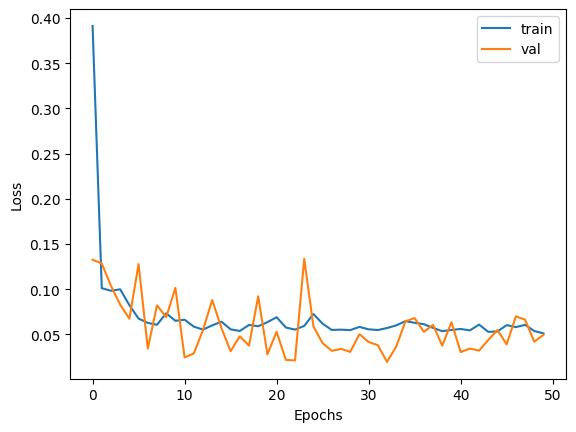

training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/LSTM_4.h5
3/3 [==============================] - 1s 8ms/step
Prediction result saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/LSTM_4.png


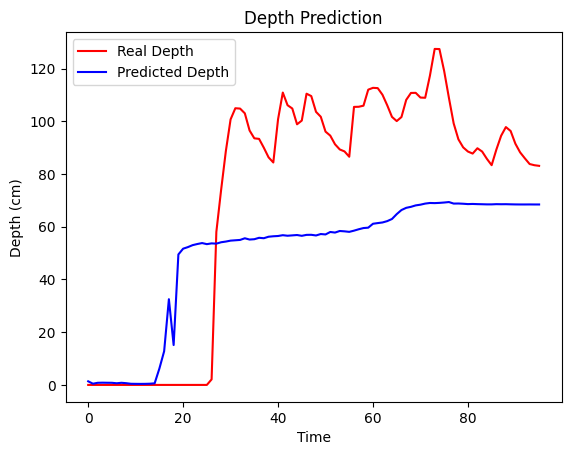

Epoch 1/50
20/20 [==============================] - 8s 75ms/step - loss: 0.1736 - val_loss: 0.1191
Epoch 2/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0912 - val_loss: 0.1126
Epoch 3/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0859 - val_loss: 0.1151
Epoch 4/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0945 - val_loss: 0.1154
Epoch 5/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0694 - val_loss: 0.1778
Epoch 6/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0671 - val_loss: 0.0620
Epoch 7/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0609 - val_loss: 0.1256
Epoch 8/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0751 - val_loss: 0.1091
Epoch 9/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0602 - val_loss: 0.0957
Epoch 10/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0496 - val_loss: 0.1341
Epoch 11/

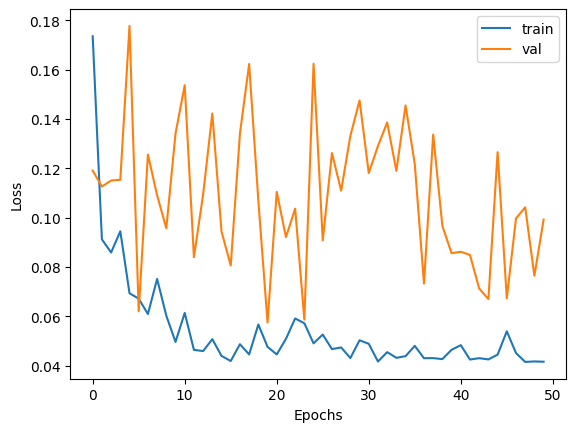

training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/LSTM_5.h5
2/2 [==============================] - 2s 13ms/step
Prediction result saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/LSTM_5.png


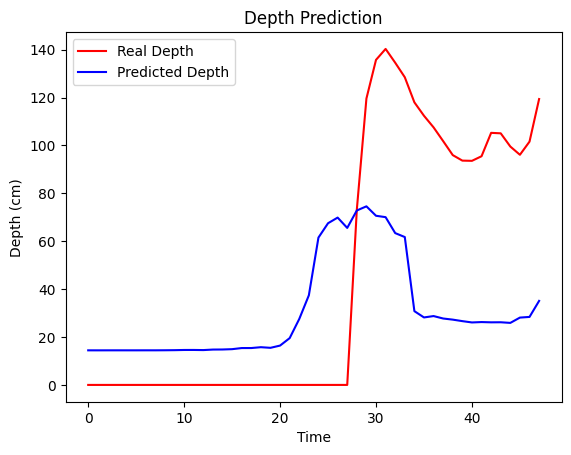

In [24]:
events = load_data(data_source)

for i in range(num_events):
  temp = events[0]
  events = events[1:]
  split_boundary = 0
  for event in events:
    split_boundary += len(event)
  events.append(temp)

  X, Y = create_sequences(events)
  nX, nY = normalize(X), normalize(Y)

  X_train, Y_train, X_test, Y_test = split_data(nX, nY, split_boundary)
  data = (X, Y, X_train, Y_train, X_test, Y_test)
  steps, features = X_train.shape[1], X_train.shape[2]

  lstm = My_LSTM()
  weights_filename = 'LSTM_' + str(i+1)
  output_filename = 'LSTM_' + str(i+1)

  model = lstm.train(data)
  lstm.save_model(model, weights_filename)

  result = lstm.predict(data, weights_filename)
  lstm.save_result(result, output_filename)
